<a href="https://colab.research.google.com/github/iSarahSajjad/neuro-chronical-prediction/blob/master/3D_Unset15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pickle
import os
import tensorflow as tf

# Directory containing the balanced batches
balanced_batch_dir = '/content/drive/My Drive/ChronicAI/dataset/preprocessed_batches'

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5772 - loss: 1.1168 
Epoch 1: val_loss improved from inf to 1.05981, saving model to /content/drive/My Drive/ChronicAI/models/3d_unet_epoch_1_01.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1178s 16s/step - accuracy: 0.5777 - loss: 1.1156 - val_accuracy: 0.5000 - val_loss: 1.0598
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6249 - loss: 0.9489 
Epoch 2: val_loss improved from 1.05981 to 1.05888, saving model to /content/drive/My Drive/ChronicAI/models/3d_unet_epoch_1_02.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1161s 16s/step - accuracy: 0.6250 - loss: 0.9489 - val_accuracy: 0.5000 - val_loss: 1.0589
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6505 - loss: 0.9194 
Epoch 3: val_loss did not improve from 1.05888
75/75 ━━━━━━━━━━━━━━━━━━━━ 1154s 15s/step - accuracy: 0.6504 - loss: 0.9193 - val_accuracy: 0.5000 - val_loss: 1.0681
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6653 - loss: 0.8

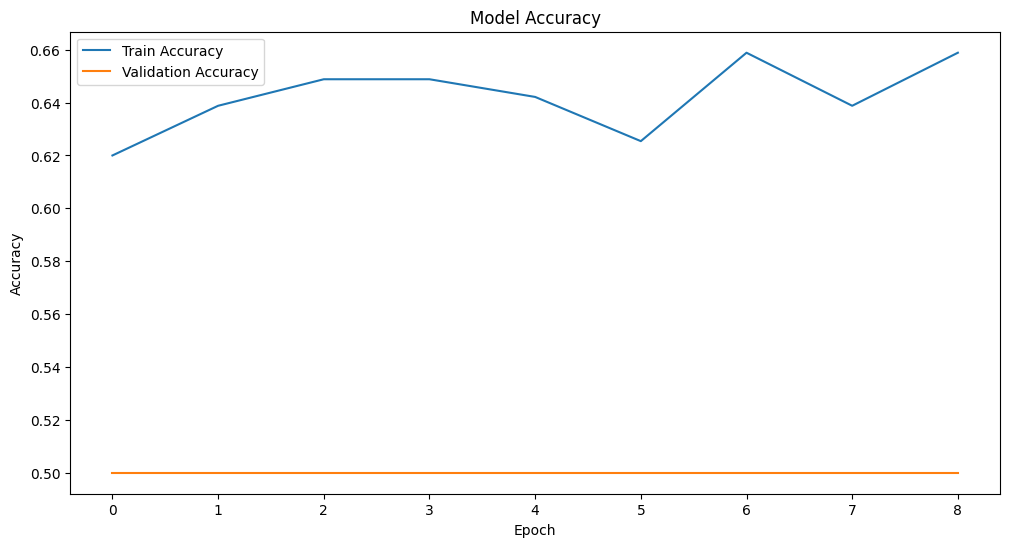

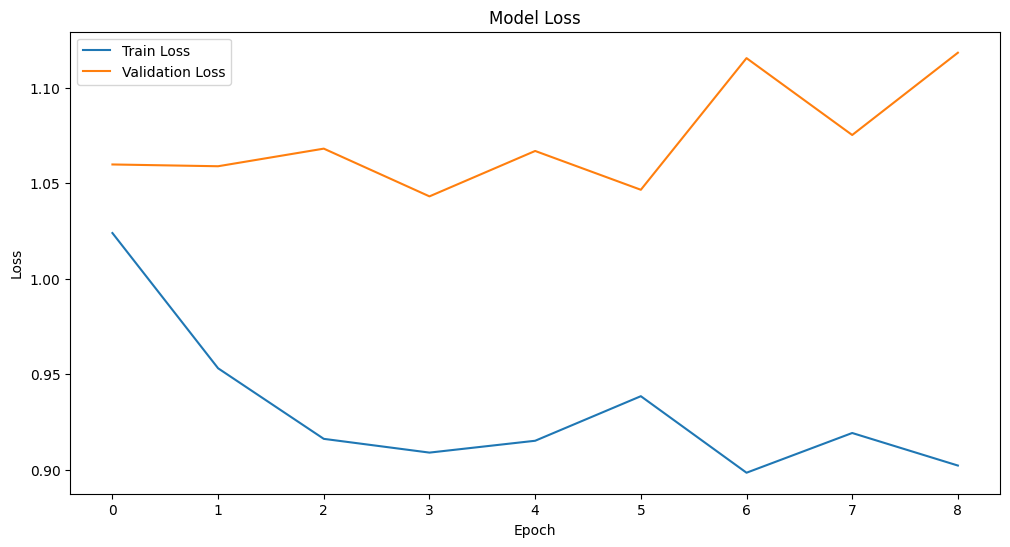

In [4]:
import numpy as np
import pickle
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_data_from_batches(batch_dir):
    batch_files = [f for f in os.listdir(batch_dir) if f.endswith('.pkl')]
    all_data = []
    all_labels = []

    for batch_file in batch_files:
        batch_path = os.path.join(batch_dir, batch_file)
        with open(batch_path, 'rb') as f:
            batch_data, batch_labels = pickle.load(f)
            all_data.append(batch_data)
            all_labels.append(batch_labels)

    # Concatenate all batches
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_data, all_labels

# Load data
X, y = load_data_from_batches(balanced_batch_dir)

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/(1-0.2), random_state=42)

# Reduce batch size
batch_size = 4

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.1
)

def generator(X, y, batch_size):
    while True:
        indices = np.arange(len(y))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

        for start in range(0, len(y), batch_size):
            end = min(start + batch_size, len(y))
            yield X[start:end], y[start:end]

train_generator = generator(X_train, y_train, batch_size)
val_generator = generator(X_val, y_val, batch_size)

# Define your model architecture
def create_model():
    input_shape = (128, 128, 128, 1)  # Adjust according to your data
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Adjust output layer according to your labels
    ])
    return model

# Create model
model = create_model()

# Compile model with a learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Checkpoint Callback
checkpoint_path = '/content/drive/My Drive/ChronicAI/models/3d_unet_epoch_1_{epoch:02d}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with the generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    epochs=15,
    callbacks=[early_stopping, checkpoint_callback]
)

# Save model
model.save('/content/drive/My Drive/ChronicAI/models/3d_unet_model_1.keras')

# Save training history
import json
with open('/content/drive/My Drive/ChronicAI/models/training_history_3d_unset.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

# Load training history
with open('/content/drive/My Drive/ChronicAI/models/training_history_3d_unset.json', 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
